<a href="https://colab.research.google.com/github/MostafaSwaisy/SVM_and_CNN_implementations_for_handwritten_digit_recognition_on_the_MNIST_dataset/blob/main/SVM_and_CNN_implementations_for_handwritten_digit_recognition_on_the_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Got 60000 training and 10000 test samples

Starting with SVM
Running PCA to make this faster...
Kept 100 components, variance: 0.91
Training SVM (this takes a while)...
Done in 45.8 seconds
Testing SVM model...
SVM accuracy: 0.9859
Prediction took 14.15 seconds


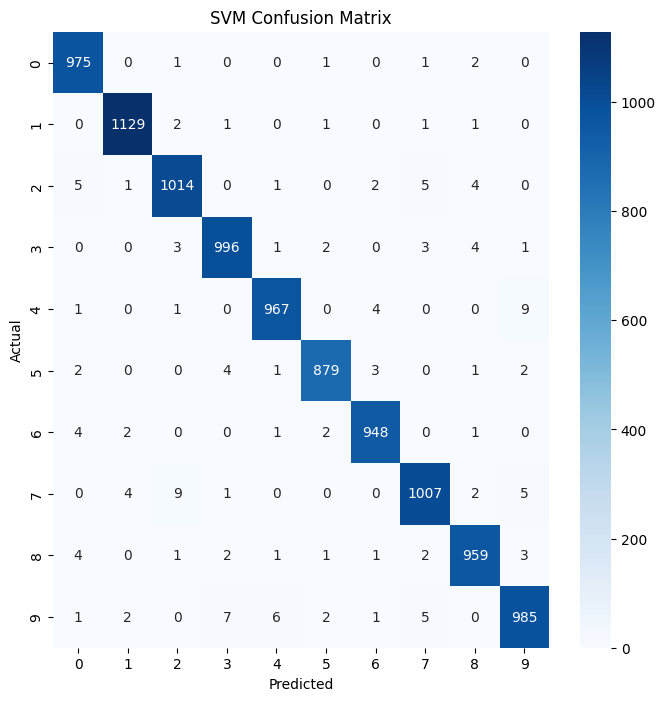


Now for CNN approach


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN now...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8487 - loss: 0.4952 - val_accuracy: 0.9817 - val_loss: 0.0550
Epoch 2/5
241/469 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9707 - loss: 0.0980

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import time

# Just fixing randomness
np.random.seed(42)
tf.random.set_seed(42)

print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"Got {len(X_train)} training and {len(X_test)} test samples")

# Let's try SVM first
print("\nStarting with SVM")

# Flatten the images for SVM
X_train_flat = X_train.reshape(len(X_train), -1) / 255.0
X_test_flat = X_test.reshape(len(X_test), -1) / 255.0

# SVM is slow on 784 dims, so use PCA
print("Running PCA to make this faster...")
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
print(f"Kept {pca.n_components} components, variance: {sum(pca.explained_variance_ratio_):.2f}")

# Train SVM
print("Training SVM (this takes a while)...")
svm_start = time.time()
model = svm.SVC(C=10, kernel='rbf', gamma='scale')
model.fit(X_train_pca, y_train)
svm_time = time.time() - svm_start
print(f"Done in {svm_time:.1f} seconds")

# Test it
print("Testing SVM model...")
svm_test_start = time.time()
y_pred_svm = model.predict(X_test_pca)
svm_test_time = time.time() - svm_test_start

svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM accuracy: {svm_acc:.4f}")
print(f"Prediction took {svm_test_time:.2f} seconds")

# Confusion matrix
plt.figure(figsize=(8,8))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Now try CNN
print("\nNow for CNN approach")

# Reshape and prepare data for CNN
X_train_cnn = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test_cnn = X_test.reshape(-1, 28, 28, 1) / 255.0

# One-hot encode the labels
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build CNN model
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
           optimizer='adam',
           metrics=['accuracy'])

# Train CNN
print("Training CNN now...")
cnn_start = time.time()
history = cnn.fit(X_train_cnn, y_train_onehot,
                 batch_size=128,
                 epochs=5,  # using 5 epochs to save time
                 validation_data=(X_test_cnn, y_test_onehot),
                 verbose=1)
cnn_time = time.time() - cnn_start
print(f"CNN training took {cnn_time:.1f} seconds")

# Test CNN
print("Testing CNN...")
cnn_test_start = time.time()
cnn_loss, cnn_acc = cnn.evaluate(X_test_cnn, y_test_onehot, verbose=0)
cnn_test_time = time.time() - cnn_test_start

# Get predicted classes
y_pred_probs = cnn.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_probs, axis=1)

print(f"CNN accuracy: {cnn_acc:.4f}")
print(f"Testing took {cnn_test_time:.2f} seconds")

# Plot CNN training history
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CNN confusion matrix
plt.figure(figsize=(8,8))
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare results
print("\nResults comparison:")
print(f"SVM: {svm_acc:.4f} accuracy, {svm_time:.1f}s training, {svm_test_time:.2f}s testing")
print(f"CNN: {cnn_acc:.4f} accuracy, {cnn_time:.1f}s training, {cnn_test_time:.2f}s testing")

# Plot comparison
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['SVM', 'CNN'], [svm_acc, cnn_acc], color=['skyblue', 'lightcoral'])
plt.title('Accuracy')
plt.ylim(0.9, 1.0)

plt.subplot(1,2,2)
plt.bar(['SVM', 'CNN'], [svm_time, cnn_time], color=['skyblue', 'lightcoral'])
plt.title('Training Time (seconds)')
plt.tight_layout()
plt.show()

print("All done!")

if __name__ == "__main__":
    pass  # everything runs at module level, no need for main function